In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
import krypy
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt

In [2]:
dist_set = np.linspace(0.5, 3.0, 11)
ub_set = [10, 10, 10, 9, 8, 6, 6, 5, 5, 4, 4]

In [29]:
CasE_01 = []
for index_ in range(len(dist_set)):
    dist = dist_set[index_]
    h = 0.1

    r1 = 1
    r2 = 1

    sphere1 = bempp.api.shapes.sphere(r = r1, h=h, origin=((dist/2) + r1, 0, 0))
    sphere2 = bempp.api.shapes.sphere(r = r2, h=h, origin=(-((dist/2) + r2), 0, 0))

    space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
    space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

    N_wn = 20
    ubound_wn = ub_set[index_]
    lbound_wn = 0
    quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)
    results = []
    for index2, point2 in enumerate(quad_points):

        wavenumber = -1j * np.log(point2)


        slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
        slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
        slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
        slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

        mat11 = slp11.weak_form().A
        mat12 = slp12.weak_form().A
        mat21 = slp21.weak_form().A
        mat22 = slp22.weak_form().A
        mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
        mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

        mat = np.block([[mat11,mat12],[mat21,mat22]])  
        mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

        n = mat.shape[0]
        Id = np.eye(n)
        inv_mat2 = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat2), Id)  # inversion of the matrix M_{\infty} computed through the LU decomposition

        combined = inv_mat2.dot(mat)
        sign, logdet = slogdet(combined)

        results.append(logdet)
    print(np.trapz(-np.array(results)/quad_points, quad_points)/(2*np.pi))
    CasE_01.append(np.trapz(-np.array(results)/quad_points, quad_points)/(2*np.pi))

0.029476036984709793
0.01298298602252645
0.007175914778469127
0.004477439468101028
0.0030204581223830453
0.0021519650273321704
0.0015963577734074042
0.0012218063936292847
0.0009588477974220234
0.0007679320617170563
0.0006257540296569306


In [100]:
CasE_01_kry = []
for index_ in range(len(dist_set)):
    dist = dist_set[index_]
    h = 0.1

    r1 = 0.5
    r2 = 1

    sphere1 = bempp.api.shapes.sphere(r = r1, h=h, origin=((dist/2) + r1, 0, 0))
    sphere2 = bempp.api.shapes.sphere(r = r2, h=h, origin=(-((dist/2) + r2), 0, 0))

    space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
    space_sphere2 = bempp.api.function_space(sphere2, "P", 1)


    N_wn = 20
    ubound_wn = ub_set[index_]
    lbound_wn = 0
    quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)

    results_kry = []
    for index2, point2 in enumerate(quad_points):

        wavenumber = -1j * np.log(point2)


        slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
        slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
        slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
        slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

        mat11 = slp11.weak_form().A
        mat12 = slp12.weak_form().A
        mat21 = slp21.weak_form().A
        mat22 = slp22.weak_form().A
        mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
        mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

        mat = np.block([[mat11,mat12],[mat21,mat22]])  
        mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

        x = np.ones(mat.shape[0]) / np.linalg.norm(np.ones(mat.shape[0]))
        rho_ = 1
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(mat.shape[0],1), maxiter = 20, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        evalue_ = evalue + rho_

        logdet_ = 0
        for eigv in evalue_:
            logdet_ += np.log(eigv)

        results_kry.append(logdet_)
    print( np.trapz(-np.array(results_kry)/quad_points, quad_points)/(2*np.pi))
    CasE_01_kry.append(np.trapz(-np.array(results_kry)/quad_points, quad_points)/(2*np.pi))

0.026005277721938648
0.012083867242717527
0.007021731697643101
0.004463023553365115
0.0030404948009809768
0.0021616654732735073
0.0016138083478833836
0.0012153797904136952
0.0009557703214040504
0.0007642799168856298
0.0006248841353453636


In [14]:
CasE_01_H = []
for index_ in range(len(dist_set)):
    dist = dist_set[index_]
    h = 0.05

    r1 = 1
    r2 = 1

    sphere1 = bempp.api.shapes.sphere(r = r1, h=h, origin=((dist/2) + r1, 0, 0))
    sphere2 = bempp.api.shapes.sphere(r = r2, h=h, origin=(-((dist/2) + r2), 0, 0))

    space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
    space_sphere2 = bempp.api.function_space(sphere2, "P", 1)


    N_wn = 20
    ubound_wn = ub_set[index_]
    lbound_wn = 0
    quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)

    results_H = []
    for index2, point2 in enumerate(quad_points):

        wavenumber = -1j * np.log(point2)


        slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
        slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
        slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
        slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

        mat11 = slp11.weak_form().A
        mat12 = slp12.weak_form().A
        mat21 = slp21.weak_form().A
        mat22 = slp22.weak_form().A
        mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
        mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

        mat = np.block([[mat11,mat12],[mat21,mat22]])  
        mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

        mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
        mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))
        inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                                  [mat21_zero, mat22_inv]])  
        combined_inverse_free = inv_free_mat2.dot(mat)
        
        n = mat.shape[0]
        X_combined, H_combined = krypy.utils.arnoldi(combined_inverse_free, (np.ones(n)/np.linalg.norm(np.ones(n))).reshape((n,1)), maxiter = 50,  ortho='dmgs')
        evals_H, evect_H = np.linalg.eig(H_combined[0:50, :])  

        logdet_ = 0 
        for i in range(len(evals_H)):
            logdet_ += np.log(evals_H[i])
        results_H.append(logdet_)
    print( np.trapz(-np.array(results_H)/quad_points, quad_points)/(2*np.pi))
    CasE_01_H.append(np.trapz(-np.array(results_H)/quad_points, quad_points)/(2*np.pi))

(0.0429736006012986+0j)
(0.019424454071944406+0j)
(0.010866848167588917+0j)
(0.006860236192820715+0j)
(0.004682038507567278+0j)
(0.0033739032324310446+0j)
(0.002530026887014172+0j)
(0.001956052970397485+0j)
(0.0015496582303256559+0j)
(0.0012520873679859848+0j)
(0.0010287597320540057+0j)


In [15]:
print(list(np.real(CasE_01_H)))

[0.0429736006012986, 0.019424454071944406, 0.010866848167588917, 0.006860236192820715, 0.004682038507567278, 0.0033739032324310446, 0.002530026887014172, 0.001956052970397485, 0.0015496582303256559, 0.0012520873679859848, 0.0010287597320540057]


In [23]:
CasE_01 =         [0.04378745428729573, 0.019405016738122838, 0.0108371211616883, 0.006839810250201529, 0.004668659979976799, 0.00336417742048196, 0.002522891816193938, 0.0019507869583254914, 0.0015456637242148548, 0.0012490025373795045, 0.0010262850146008139]
CasE_01_kry100 =  [0.043530368033945444, 0.019374507178161863, 0.010821448653923676, 0.00682958894772926, 0.004661255358002596, 0.0033585361926878683, 0.002518362389993664, 0.0019470664673295456, 0.0015424627814774052, 0.0012462239050645982, 0.0010237493962096849]
CasE_01_kry50 =   [0.04261267115423324, 0.019333294508637147, 0.010811481005476688, 0.006825395064294098, 0.004658008383880573, 0.0033575860644537454, 0.002517756523412413, 0.0019466262961202105, 0.0015421832085693084, 0.001246040599833494, 0.0010235790027556231]
CasE_01_kry20 =  [0.039646317449486566, 0.01959631427145057, 0.011189248490255975, 0.006718853352526621, 0.004661332415810963, 0.0033349481214446594, 0.002476463325983571, 0.0019160815985319304, 0.0015234686312888077, 0.0012358032553910663, 0.0010181966245469162]

CasE_01_H100 = [0.043704022590485836, 0.01940237697329161, 0.010836916114642225, 0.0068398400058791095, 0.004668665577718678, 0.0033641776132173644, 0.0025228925911053904, 0.0019507868229773674, 0.0015456637107085322, 0.001249002501735385, 0.0010262850004214747]
CasE_01_H50 = [0.04269143238819492, 0.0193535216612659, 0.010819472129949746, 0.006835486327182621, 0.004667477079359019, 0.003363382131934474, 0.0025225305147067163, 0.001950631094703194, 0.0015455794736189993, 0.0012489834319356105, 0.00102627246769588]
CasE_01_H20 = [0.031477852410740165, 0.017120757427632954, 0.010050633847186232, 0.006656074045582805, 0.0045185297267752635, 0.003276878162775849, 0.0024705860920205616, 0.001981209808629849, 0.001547779136399169, 0.001245556715001038, 0.001011055188257731]

CasE_005 =        [0.04414292087373472, 0.019512906114365014, 0.010885881395436363, 0.006866209609433243, 0.004684502446229281, 0.003374631416344333, 0.0025301979276258053, 0.00195612065198951, 0.0015496951977321941, 0.001252134039741458, 0.0010287807049493398]
CasE_005_kry100 = [0.043953293967728485, 0.019489846361178755, 0.010876617015043893, 0.006860682753979697, 0.004680470195019519, 0.0033715490555184793, 0.0025278183912557945, 0.0019541702273667668, 0.0015480637608446507, 0.0012507244821631392, 0.0010275541123076432]
CasE_005_kry50 =  [0.042948709212460724, 0.01941016729221614, 0.010852599970610914, 0.00685394620425048, 0.004678621416483789, 0.0033707027261574733, 0.002527253234342069, 0.001953792146291252, 0.0015479003369944704, 0.001250608150691174, 0.001027493153657424]
CasE_005_kry20 =  [0.03479142079712287, 0.01948681368514115, 0.010886850835208446, 0.0068627697550302505, 0.0044711697995858165, 0.0032353529622154665, 0.002453455631460141, 0.0019227075614918236, 0.0015343678890540338, 0.001238778609736291, 0.001020725241257602]

CasE_005_H100 = [0.044079600690756414, 0.019507674580007094, 0.010885384160911943, 0.006866147266915436, 0.004684495378911524, 0.0033746285775524886, 0.002530197031923786, 0.001956120566130516, 0.001549695150368064, 0.0012521339803545162, 0.0010287806939069544]
CasE_005_H50 = [0.0429736006012986, 0.019424454071944406, 0.010866848167588917, 0.006860236192820715, 0.004682038507567278, 0.0033739032324310446, 0.002530026887014172, 0.001956052970397485, 0.0015496582303256559, 0.0012520873679859848, 0.0010287597320540057]
CasE_005_H20 = [0.0429736006012986, 0.019424454071944406, 0.010866848167588917, 0.006860236192820715, 0.004682038507567278, 0.0033739032324310446, 0.002530026887014172, 0.001956052970397485, 0.0015496582303256559, 0.0012520873679859848, 0.0010287597320540057]

CasE_extrap =        [0.044261409735881045, 0.01954886923977907, 0.010902134806685717, 0.006875009395843815, 0.004689783268313442, 0.0033781160816317908, 0.002532633298103094, 
                      0.0019578985498775164, 0.001551039022237974, 0.001253177873862109, 0.0010296126017321817]
CasE_extrap_kry100 = [0.0440942692789895, 0.01952829275551772, 0.010895006468750633, 0.006871047356063176, 0.004686875140691826, 0.0033758866764620164, 0.0025309703916765046, 
                      0.001956538147379174, 0.0015499307539670658, 0.0012522246745293195, 0.0010288223510069626]
CasE_extrap_kry50 =  [0.043060721898536554, 0.019435791553409135, 0.010866306292322322, 0.006863463250902607, 0.004685492427351528, 0.0033750749467253826, 0.002530418804651954, 0.0019561807630149326, 0.0015498060464695243, 0.001252130667643734,0.001028797870624691]
CasE_extrap_kry20 = [0.03317312191300164, 0.019450313489704676, 0.01078605161685927, 0.006910741889198127, 0.004407782260844101, 0.0032021545758057356, 0.002445786399952331, 
                     0.001924916215811788, 0.0015380009749757758, 0.0012397703945180327, 0.0010215681134944975]

CasE_extrap_H100 = [0.044204793390846604, 0.019542773782245587, 0.010901540176335182, 0.006874916353927545, 0.0046897719793091396, 0.0033781122323308633, 0.0025326318455299182, 
                    0.001957898480514899, 0.0015510389635879078, 0.0012531778065608932, 0.0010296125917354476]
CasE_extrap_H50 = [0.043067656672333164, 0.01944809820883724, 0.010882640180135307, 0.006868486148033413, 0.004686892316970031, 0.0033774102659299013, 0.002532525677783324, 
                   0.0019578602622955816, 0.0015510178158945414, 0.0012531220133361095, 0.001029588820173381]
CasE_extrap_H20 = [0.04680551666481808, 0.020192352953381558, 0.011138919607723145, 0.0069282902419000175, 0.004736541434497949, 0.00340624492231611, 
                   0.0025498404853453757, 0.0019476673576533635, 0.0015502845949678181, 0.0012542642523143005, 0.0010346612466527638]
#=============================================================================================================================================================
CasE_01_un =         [0.029476036984709793, 0.01298298602252645,  0.007175914778469127, 0.004477439468101028, 0.0030204581223830453, 0.0021519650273321704, 0.0015963577734074042, 0.0012218063936292847, 0.0009588477974220234, 0.0007679320617170563, 0.0006257540296569306]
CasE_01_kry100_un =  [0.02936370312900224,  0.012960106599049934, 0.007164394990983271, 0.004469546774441836, 0.003014262071526835, 0.002147181140299296, 0.0015922958547462903, 0.0012184821952177722, 0.0009558932125023755, 0.0007653599198454827, 0.0006234839003009436]
CasE_01_kry50_un  =  [0.02910606536630689,  0.012935222838784599, 0.0071587336934454335, 0.004467834449128334, 0.003013760112704111, 0.0021462563505965657, 0.0015914948268125643, 0.001217885281141225, 0.00095538398495521, 0.0007648755657816093, 0.0006229489070703005]
CasE_01_kry20_un =   [0.026005277721938648, 0.012083867242717527, 0.007021731697643101, 0.004463023553365115, 0.0030404948009809768, 0.0021616654732735073, 0.0016138083478833836, 0.0012153797904136952, 0.0009557703214040504, 0.0007642799168856298, 0.0006248841353453636]

CasE_005_un =        [0.029860930637409303, 0.01310530816200317, 0.007232735164191662, 0.004508661750202899, 0.003039811884614853, 0.0021648031512201396, 0.0016054650738438461, 0.0012285139086995445, 0.0009639527656717357, 0.0007719176225677768, 0.0006289450587547911]
CasE_005_kry100_un = [0.029818311802804438, 0.013093433040329484, 0.007226501560691791, 0.004504363635191474, 0.00303645588477618, 0.0021620766356283713, 0.00160324255091669, 0.0012266606239260192, 0.0009623895440108256, 0.0007705673724587229, 0.0006277701622360108]
CasE_005_kry50_un  = [0.029697000276674268, 0.013090662203617162, 0.0072289065045610485, 0.004505166561468254, 0.003036732975955927, 0.0021624150914408154, 0.001603490860329592, 0.0012268320153391602, 0.0009625060028623015, 0.0007706520960952093, 0.0006278234601602794]
CasE_005_kry20_un  = [0.02918716574545922,  0.013012100643572683, 0.006885559199383792, 0.0043562072175545976, 0.0030565284030248997, 0.002184711577047818, 0.00160806973768642, 0.0012232592009224902, 0.0009615331260348184, 0.0007703798444249834, 0.0006268037409753391]

CasE_extrap_un =        [0.029989228521642472, 0.013146082208495412, 0.00725167529276584, 0.004519069177570189, 0.0030462631386921225, 0.0021690825258494626, 0.0016085008406559935, 0.0012307497470562978, 0.0009656544217549731, 0.0007732461428513503, 0.0006300087351207446]
CasE_extrap_kry100_un = [0.02996984802740517, 0.013137875187422668, 0.007247203750594631, 0.004515969255441354, 0.0030438538225259614, 0.0021670418007380633, 0.0016068914496401565, 0.0012293867668287683, 0.0009645549878469756, 0.0007723031899964696, 0.0006291989162143665]
CasE_extrap_kry50_un  = [0.02989397858013006, 0.013142475325228017, 0.007252297441599587, 0.004517610598914894, 0.0030443905970398656, 0.0021678013383888985, 0.0016074895381686012, 0.0012298142600718053, 0.0009648800088313319, 0.0007725776061997426, 0.0006294483111902723]
CasE_extrap_kry20_un =  [0.030247795086632744, 0.01332151177719107, 0.006840168366630689, 0.004320601772284425, 0.003061872937039541, 0.0021923936116392552, 0.0016061568676207655, 0.0012258856710920885, 0.0009634540609117411, 0.0007724131536047679, 0.0006274436095186643]


In [119]:
CasE_005_kry50_un[1] + (CasE_005_kry50_un[1] - CasE_01_kry50_un[1])/(2**2 - 1)

0.013142475325228017

In [120]:
CasE_005_kry100_un[1] + (CasE_005_kry100_un[1] - CasE_01_kry100_un[1])/(2**2 - 1)

0.013137875187422668

In [22]:
for i in range(len(CasE_005)):
    print(CasE_005_H50[i] + (CasE_005_H50[i] - CasE_01_H50[i])/(2**2 - 1))

0.043067656672333164
0.01944809820883724
0.010882640180135307
0.006868486148033413
0.004686892316970031
0.0033774102659299013
0.002532525677783324
0.0019578602622955816
0.0015510178158945414
0.0012531220133361095
0.001029588820173381


In [130]:
for i in range(len(CasE_005)):
    print(CasE_005_kry20[i] + (CasE_005_kry20[i] - CasE_01_kry20[i])/(2**2 - 1))

0.03317312191300164
0.019450313489704676
0.01078605161685927
0.006910741889198127
0.004407782260844101
0.0032021545758057356
0.002445786399952331
0.001924916215811788
0.0015380009749757758
0.0012397703945180327
0.0010215681134944975


In [132]:
err_100 = []
for i in range(len(CasE_005_kry100)):
    err_100.append(abs(CasE_extrap[i] - CasE_extrap_kry100[i])/abs(CasE_extrap[i]))
err_50 = []
for i in range(len(CasE_005_kry100)):
    err_50.append(abs(CasE_extrap[i] - CasE_extrap_kry50[i])/abs(CasE_extrap[i])) 
err_20 = []
for i in range(len(CasE_005_kry100)):
    err_20.append(abs(CasE_extrap[i] - CasE_extrap_kry20[i])/abs(CasE_extrap[i]))

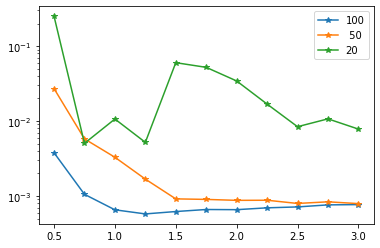

In [133]:
plt.semilogy(dist_set, err_100, '*-')
plt.semilogy(dist_set, err_50, '*-')
plt.semilogy(dist_set, err_20, '*-')
plt.legend(['100', ' 50' , '20'])

In [125]:
err_100_un = []
for i in range(len(CasE_005_kry100_un)):
    err_100_un.append(abs(CasE_extrap_un[i] - CasE_extrap_kry100_un[i])/abs(CasE_extrap_un[i]))
    
err_50_un = []
for i in range(len(CasE_005_kry50_un)):
    err_50_un.append(abs(CasE_extrap_un[i] - CasE_extrap_kry50_un[i])/abs(CasE_extrap_un[i]))
    
err_20_un = []
for i in range(len(CasE_005_kry50_un)):
    err_20_un.append(abs(CasE_extrap_un[i] - CasE_extrap_kry20_un[i])/abs(CasE_extrap_un[i]))

In [98]:
err_100_un

[0.000646248509637947,
 0.0006242940628684239,
 0.0006166219515743523,
 0.0006859647434081085,
 0.0007909087483478081,
 0.0009408240982440919,
 0.0010005534191580604,
 0.0011074389661988712,
 0.001138537641653818,
 0.0012194730793011809,
 0.0012854090129764389]

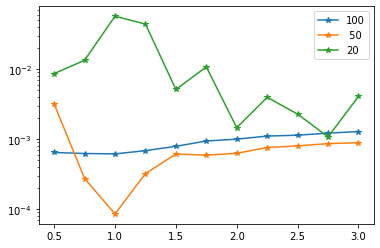

In [126]:
plt.semilogy(dist_set, err_100_un, '*-')
plt.semilogy(dist_set, err_50_un, '*-')
plt.semilogy(dist_set, err_20_un, '*-')

plt.legend(['100', ' 50', '20'])

In [11]:
h = 0.1

r1 = 1
r2 = 1

dist = 2.75
sphere1 = bempp.api.shapes.sphere(r = r1, h=h, origin=((dist/2) + r1, 0, 0))
sphere2 = bempp.api.shapes.sphere(r = r2, h=h, origin=(-((dist/2) + r2), 0, 0))

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

ubound_wn = 4
lbound_wn = 0
#quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)
results = []
for point2 in np.arange(1, ubound_wn + 1, 1):

    wavenumber = 1j * point2


    slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
    slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
    slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
    slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

    mat11 = slp11.weak_form().A
    mat12 = slp12.weak_form().A
    mat21 = slp21.weak_form().A
    mat22 = slp22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

    n = mat.shape[0]
    Id = np.eye(n)
    inv_mat2 = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat2), Id)  # inversion of the matrix M_{\infty} computed through the LU decomposition

    combined = inv_mat2.dot(mat)
    sign, logdet = slogdet(combined)

    results.append(logdet)

In [12]:
results[-1]

-6.155298493126925e-12

In [7]:
(-9.276720948337981e-06 + (-2.829292355954916e-12)) * (10 - 25) /2

6.957542833222753e-05

In [ ]:
-2.829292355954916e-12

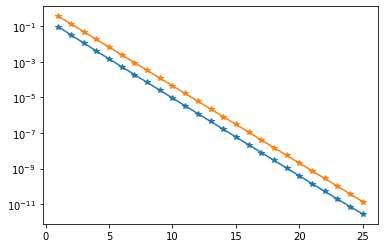

In [5]:
plt.semilogy(np.arange(1, ubound_wn + 1 , 1), -np.array(results), '*-')
plt.semilogy(np.arange(1, ubound_wn + 1 , 1), np.exp(-2*dist*np.arange(1, ubound_wn + 1 , 1)), '*-')

In [14]:
h = 0.1

r1 = 1
r2 = 1

dist = 2.75
sphere1 = bempp.api.shapes.sphere(r = r1, h=h, origin=((dist/2) + r1, 0, 0))
sphere2 = bempp.api.shapes.sphere(r = r2, h=h, origin=(-((dist/2) + r2), 0, 0))

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

N_wn = 20
ubound_wn = 4
lbound_wn = 0
quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)
results = []
for index2, point2 in enumerate(quad_points):

    wavenumber = -1j * np.log(point2)


    slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
    slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
    slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
    slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

    mat11 = slp11.weak_form().A
    mat12 = slp12.weak_form().A
    mat21 = slp21.weak_form().A
    mat22 = slp22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

    n = mat.shape[0]
    Id = np.eye(n)
    inv_mat2 = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat2), Id)  # inversion of the matrix M_{\infty} computed through the LU decomposition

    combined = inv_mat2.dot(mat)
    sign, logdet = slogdet(combined)

    results.append(logdet)
print(np.trapz(-np.array(results)/quad_points, quad_points)/(2*np.pi))

0.0012490025373795045


In [20]:
N_wn = 20
ubound_wn = 7
lbound_wn = 0
quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)

results_kry = []
for index2, point2 in enumerate(quad_points):

    wavenumber = -1j * np.log(point2)


    slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
    slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
    slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
    slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

    mat11 = slp11.weak_form().A
    mat12 = slp12.weak_form().A
    mat21 = slp21.weak_form().A
    mat22 = slp22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

    x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))
    rho_ = 1
    V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(mat.shape[0],1), maxiter = 100, ortho ='dmgs')
    A_m = V_m.T @ (mat - rho_*mat2) @ V_m
    B_m = V_m.T @ mat2 @ V_m
    evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
    evalue_ = evalue + rho_

    logdet_ = 0
    for eigv in evalue_:
        logdet_ += np.log(eigv)

    results_kry.append(logdet_)
err_ = abs(np.trapz(-np.array(results_kry)/quad_points, quad_points)/(2*np.pi) -0.04378745428729573)/0.04378745428729573
print(ubound_wn, np.trapz(-np.array(results_kry)/quad_points, quad_points)/(2*np.pi), err_)

7 0.043678933414259574 0.002478355382894314


In [64]:
mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                          [mat21_zero, mat22_inv]])  

combined_inverse_free = inv_free_mat2.dot(mat)

In [78]:
err_arno = []
for dim in np.arange(5, 500+5, 5):
    X_combined, H_combined = krypy.utils.arnoldi(combined_inverse_free, x.reshape(combined.shape[0],1), maxiter = dim,  ortho='dmgs')
    evals_H, evect_H = np.linalg.eig(H_combined[0:dim, :])
    logdet_ = 0
    for eigv in evals_H:
        logdet_ += np.log(eigv)
    err_arno.append(abs(logdet_ - logdet)/abs(logdet))

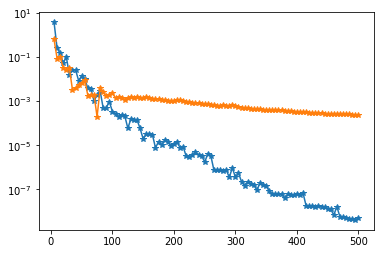

In [80]:
plt.semilogy(np.arange(5, 500+5, 5), err_arno, '*-')
plt.semilogy(np.arange(5,500+5, 5), err_exact_1,'*-')

In [75]:
X_combined, H_combined = krypy.utils.arnoldi(combined_inverse_free, x.reshape(combined.shape[0],1), maxiter = 2,  ortho='dmgs')
evals_H, evect_H = np.linalg.eig(H_combined[0:2, :])
logdet_ = 0
for eigv in evalue:
    logdet_ += np.log(eigv)
print(abs(logdet_ - logdet)/abs(logdet))

0.00023495973729251084
